In [539]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [540]:
dataset_path = '../data/'

pollen_test = pd.read_csv(dataset_path + 'pollen_test.csv')
pollen_train = pd.read_csv(dataset_path + 'pollen_train.csv')
pollen_type = pd.read_csv(dataset_path + 'pollen-type.csv')
submission_example = pd.read_csv(dataset_path + 'submission_example.csv')
weather_data = pd.read_csv(dataset_path + 'weather_data.csv')

In [541]:
weather_data.head()

,Unnamed: 0,location,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,0,КРАГУЈЕВАЦ,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,КРАГУЈЕВАЦ,2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,КРАГУЈЕВАЦ,2016-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,КРАГУЈЕВАЦ,2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,КРАГУЈЕВАЦ,2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [542]:
weather_data.drop(['Unnamed: 0', 'snow', 'wpgt', 'tsun', 'prcp', 'tmin', 'tmax'], axis=1, inplace=True)

In [543]:
# accumulate weather_data by date but not including the year
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data['date'] = weather_data['date'].dt.strftime('%m-%d')
weather_data = weather_data.groupby('date').mean().reset_index()

In [544]:
weather_data.head()

,date,tavg,wdir,wspd,pres
0,01-01,1.914634,211.518519,6.870588,1024.089655
1,01-02,3.139024,192.357143,10.060000,1022.161290
2,01-03,2.276190,194.172414,12.116667,1019.648387
3,01-04,1.636585,184.285714,8.700000,1018.196552
4,01-05,3.682927,223.321429,11.185294,1014.234483


In [545]:
# Merge train_data and weather_data by date but not including the year

pollen_train['date'] = pd.to_datetime(pollen_train['date'])
pollen_train['date'] = pollen_train['date'].dt.strftime('%m-%d')
pollen_train = pollen_train.merge(weather_data, on='date', how='left')

pollen_test['date'] = pd.to_datetime(pollen_test['date'])
pollen_test['date'] = pollen_test['date'].dt.strftime('%m-%d')
pollen_test = pollen_test.merge(weather_data, on='date', how='left')

In [546]:
pollen_train = pollen_train.groupby('date').mean().reset_index()

pollen_test = pollen_test.groupby('date').mean().reset_index()

In [547]:
pollen_train.shape

(290, 32)

In [548]:
columns = pollen_train.columns.tolist()

In [549]:
pollen_train.head()

,date,Unnamed: 0,ACER,ALNUS,AMBROSIA,ARTEMISIA,BETULA,CANNABACEAE,CARPINUS,CELTIS,...,QUERCUS,RUMEX,SALIX,TILIA,ULMACEAE,URTICACEAE,tavg,wdir,wspd,pres
0,01-07,21666.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,-0.614286,246.066667,8.752778,1022.093750
1,01-27,29272.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,1.253659,224.740741,8.097059,1019.548276
2,01-28,26998.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,2.008889,180.314286,9.372500,1016.988889
3,01-29,21018.5,0.000000,0.166667,0.000000,0.0,3.833333,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.166667,0.0,2.964444,221.258065,7.989474,1017.647222
4,01-30,18380.5,0.166667,5.833333,0.666667,0.0,5.166667,0.0,0.5,0.0,...,0.0,0.0,0.166667,0.0,0.000000,0.0,3.506818,181.967742,9.408333,1015.614706


In [550]:
pollen_train.shape

(290, 32)

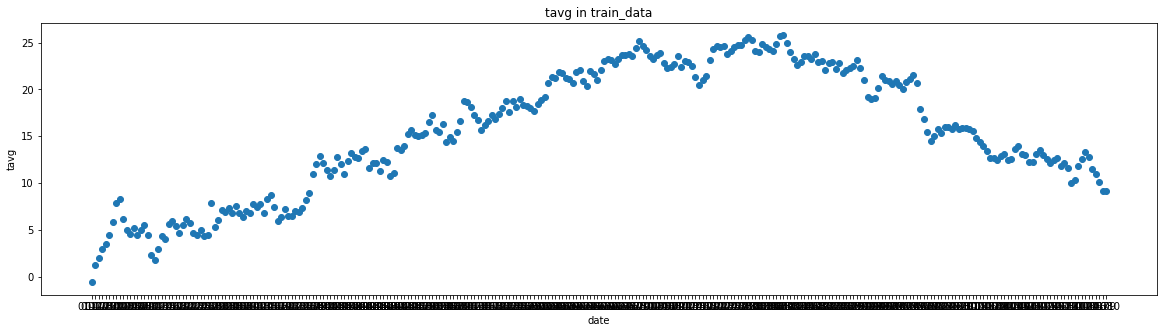

In [551]:
# plot tavg in train_data

plt.figure(figsize=(20, 5))
plt.scatter(pollen_train['date'], pollen_train['tavg'])
plt.title('tavg in train_data')
plt.xlabel('date')
plt.ylabel('tavg')
plt.show()

In [552]:
# fill pollen_train with 0 if date is missing

date = pd.date_range(start='2016-01-01', end='2016-12-31')
date = date.strftime('%m-%d')
date = pd.DataFrame(date, columns=['date'])

# merge date and pollen_train
pollen_train = date.merge(pollen_train, on='date', how='left')
pollen_train = pollen_train.fillna(0)

In [553]:
# fill pollen_train with 0 if date is missing

date = pd.date_range(start='2016-01-01', end='2016-12-31')
date = date.strftime('%m-%d')
date = pd.DataFrame(date, columns=['date'])

## XGBoost data

In [554]:
import warnings
import copy
warnings.filterwarnings('ignore')

In [555]:
# Make new dataset row consisting of 10 consecutive dates in pollen_train

new_pollen_train = pd.DataFrame()
new_pollen_val = pd.DataFrame()
new_pollen_test = pd.DataFrame()

# iterate trough pollen_train
for i in range(0, len(pollen_train)-11, 1):
    if i % 100 == 0:
        print("Batch: ", i)

    # get 10 consecutive rows
    train_rows = copy.deepcopy(pollen_train.iloc[i:i+10])
    start_date = train_rows.iloc[0]['date']
    train_rows.drop(['date'], axis=1, inplace=True)
    train_rows_mean = train_rows.mean()
    train_rows_mean['date'] = start_date

    new_pollen_train = new_pollen_train.append(train_rows_mean, ignore_index=True)

    val_rows = copy.deepcopy(pollen_train.iloc[i+10:i+11])
    new_pollen_val = new_pollen_val.append(val_rows, ignore_index=True)


Batch:  0
Batch:  100
Batch:  200
Batch:  300


In [556]:
new_pollen_train.drop(['Unnamed: 0'], axis=1, inplace=True)
new_pollen_val.drop(['Unnamed: 0'], axis=1, inplace=True)
pollen_test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [557]:
new_pollen_train.head()

,ACER,ALNUS,AMBROSIA,ARTEMISIA,BETULA,CANNABACEAE,CARPINUS,CELTIS,CHENOP/AMAR.,CORYLUS,...,RUMEX,SALIX,TILIA,ULMACEAE,URTICACEAE,tavg,wdir,wspd,pres,date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.061429,24.606667,0.875278,102.209375,01-01
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.061429,24.606667,0.875278,102.209375,01-02
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.061429,24.606667,0.875278,102.209375,01-03
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.061429,24.606667,0.875278,102.209375,01-04
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.061429,24.606667,0.875278,102.209375,01-05


In [558]:
new_pollen_val.head()

,date,ACER,ALNUS,AMBROSIA,ARTEMISIA,BETULA,CANNABACEAE,CARPINUS,CELTIS,CHENOP/AMAR.,...,QUERCUS,RUMEX,SALIX,TILIA,ULMACEAE,URTICACEAE,tavg,wdir,wspd,pres
0,01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [559]:
pollen_test['batch_id']

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
       ...  
155    109.0
156    109.0
157    109.0
158    109.0
159    109.0
Name: batch_id, Length: 160, dtype: float64

## Save CSV

In [560]:
# save new_pollen_train and new_pollen_test

new_pollen_train.to_csv(dataset_path + 'new_pollen_train.csv', index=False)
new_pollen_val.to_csv(dataset_path + 'new_pollen_val.csv', index=False)
new_pollen_test.to_csv(dataset_path + 'new_pollen_test.csv', index=False)